In [1]:
import os 
import json
from os.path import splitext,basename
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Move functions into utils
from utils import detect_lp

from keras.models import model_from_json
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder


# Import libraries for car detection
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import detectron2
from detectron2.utils.logger import setup_logger
# setup_logger()

# # import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Using TensorFlow backend.


1.5.0+cu101 True


# Vehicle Detection Component

In [2]:
# Car detection module
def cfg_detectron():
    '''
    Detectron2 configuration
    Output: Returns a predictor using FasterRCNN
    '''
    cfg = get_cfg()
    # Go to model_zoo and choose a config file for a model - Go to GitHub
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    return cfg, predictor

def prune_class(output):
    '''
    Function prunes classes from predicted output to only contain class 'car'
    Input: predicted output
    Output: NewInstance with only class, scores, bboxes from car instances
    '''
    # 1. Make variable reference to output 
    img_size = outputs["instances"].image_size
    cls = outputs["instances"].pred_classes
    scores = outputs['instances'].scores
    boxes = outputs['instances'].pred_boxes

    # 2. Remove non-car classes - car class = 2?
    # flatten tensor to list
    cls_to_list = cls.flatten().tolist()
    # list comprehension to build list with index wherever value != 2 in class list
    indx_to_remove = [ind if val!=2 else None for (ind, val) in enumerate(cls_to_list)]
    # filter None and return list
    indx_to_remove = list(filter(lambda x: isinstance(x, int), indx_to_remove))

    # 3. Delete corresponding arrays
    cls = np.delete(cls.cpu().numpy(), indx_to_remove)
    scores = np.delete(scores.cpu().numpy(), indx_to_remove)
    # WORKAROUND for numpy.ndarray - loops through boxes.tensor and remove tensor 
    # index-wise, stack bbox tensors back into one tensor
    car_boxes = []
    for ind, tensor in enumerate(boxes.tensor):
      if ind not in indx_to_remove:
        car_boxes.append(tensor)
      else: continue

    # Initialize cars_list: a list of dictionary to store all cars instances     
    cars_list = []
    try:
        car_box_tensor = torch.stack(car_boxes)
        bbox_list = car_box_tensor.tolist()

        # for-loop to save imgsize, cls, scores, car bbox instances 
        for ind, instance in enumerate(cls):
          bbox = bbox_list[ind]
          x, y, w, h = bbox

          car = {
#             'imgPath': jpgfile,
#             'imgEncode': imgEncoding,
            'class': 'car',
            'x': x,
            'y': y,
            'w': w,
            'h': h,
          }

          cars_list.append(car)

        # 4. Convert back to tensor and move to cuda
        cls = torch.tensor(cls).to('cuda:0')
        scores = torch.tensor(scores).to('cuda:0')
        boxes.tensor = car_box_tensor

        # 5. Create new instance object and set its fields
        obj = detectron2.structures.Instances(image_size=img_size)
        obj.set('pred_classes', cls)
        obj.set('scores', scores)
        obj.set('pred_boxes', boxes)

        newInstance = {'instances': obj}
        
        return newInstance, cars_list
    
   # RuntimeError when torch.stack fail to stack empty car_box_tensor array
    except RuntimeError:

        return {}, cars_list


# WPOD-NET Component

In [86]:
# WPOD-NET Module: 
# preprocess_input (Preprocess car image input)
# detect_plate (detects LP given an image)
# load_model (loads pretrained wpod-net)

def load_model(model_path, model_weights):
    '''
    Input (STR): path to model.json, model.h5
    reads the model path, get model architecture from .json then load
    the weights from .h5 
    '''
    try:
        # parse json string to initialize model instance       
        with open(model_path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects=None)
        # load model weights
        model.load_weights(model_weights)
        print('Loaded WPOD-NET successfully...')
        
        return model
    except Exception as e:
        print(e)

def preprocess_input(image, resize=False):
    '''
    Function preprocess the image input before feeding it to WPOD-NET
    Input: An image (np.ndarray), (Bool) resize
    Output: processed version of image
    '''
#     im = cv2.imread(img_path)
    # convert to RGB
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # standardize pixels between 0 and 1     
    im = im / 255
    # resize: if dim not (224,224)    
    if resize:
        im = cv2.resize(im, (224,224))
    return im


def detect_plate(image, model):
    '''
    Input: An image (np.ndarray)
    Function calculates the Resizing-Factor mentioned in the paper
    Dmin = 288 and Dmax = 608 are chosen such that it produces optimal
        results between accuracy and running time
    Output: Lp image and coordinates for detected LP
    '''
    Dmax = 608
    Dmin = 288
    bbox = preprocess_input(image)
    # get width:height image ratio     
    ratio = float(max(bbox.shape[:2]) / min(bbox.shape[:2]))
    size = int(ratio*Dmin)
    bound = min(size, Dmax)
    # Detect LP with wpod-net
    try:
        _ , LpImg, _, cor = detect_lp(model, bbox, bound, lp_threshold=0.5)
        return LpImg, cor
    except TypeError:
        print('No LP detected, return None')
        return None, None


def lp_recognition(cars, model):
    '''
    Input: List of dictionarys (key:id, val:np.ndarray images)
    Output: List of dictionarys np.ndarray images of detected LPs
    '''
#     wpod_net = load_model('../model/wpod-net.json', '../model/wpod-net.h5')
    lps = []
    
    for car in cars:
        try:
            im = car['image']
            LpImg, _ = detect_plate(im, model)
            lp = {
                'id': car['id'],
                'lp': LpImg[0]
            }
            lps.append(lp)
            
        except TypeError:
            lp = {
                'id': car['id'],
                'lp': None
            }
            lps.append(lp)
        
    return lps



# OCR Component (Segmentation & Recognition)

In [4]:
# Modified MobileNetv2 Module: Preprocess -> get contours -> sort contours -> cropped characters
# process_lp (Preprocess LP for segmentation)
# sort_contours (Sort a list of contours)

def process_lp(image):
    '''
    Function blurs, de-noise, binary, dilate image
    Input: np.ndarray
    '''
    # Convert from (0,1) to (1,255)
    im = cv2.convertScaleAbs(image, alpha=(255.0))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.GaussianBlur(im, (7, 7), 0)
    _, im = cv2.threshold(im, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    dilation_filter3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    im = cv2.dilate(im, dilation_filter3, iterations=1)

    return im

def sort_contours(cnts, reverse=False):
    '''
    Function sorts a list of contours for each segmented character
    Input (list of contours (list)) and grab each contour bbox 
    '''
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts


def segmentation(image, ratio_lower=1, ratio_upper=5):
    '''
    Function enbodies all procedures in character segmentation
    Input: Image path
    Output: a list of cropped image characters 
    '''
    # Perform image processing on input LP     
    processed_im = process_lp(image)
    contour, _ = cv2.findContours(processed_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Initialize a list which will be used to append charater image
    crop_characters = []
    digit_w, digit_h = 30, 60
    
    # Loop through the list of contours to get bounding box on character      
    for c in sort_contours(contour):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w

        # Select contours that satisfy both conditions     
        if ratio_lower<=ratio<=ratio_upper and h/processed_im.shape[0]>=0.2: 

                # Draw bounding box arroung digit number
                # cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Seperate number and give prediction
                curr_num = processed_im[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY)
                crop_characters.append(curr_num)
    
    return crop_characters
            
# Load Recognition model architecture, weights and classes
def load_recognition(json_model, model_weights, labels_file):
    '''
    Function: Loads recognition model with architecture and weights, and load class labels
    Input: path to model architecture, weights and class labels files
    '''
    with open(json_model,'r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(model_weights)

    labels = LabelEncoder()
    labels.classes_ = np.load(labels_file)

    
    return model, labels



def predict_char(image):
    '''
    Function: Run recognition on an image
    Input: Binary image
    Output: Predicted classes of image
    '''
    # Preprocess image and Predict
    im = cv2.resize(image, (128, 128))
    im = np.stack((im,)*3, axis=-1)
    im = im[np.newaxis,:]
    
    result = labels.inverse_transform([np.argmax(model.predict(im))])
    return result


def detect_lp_chars(crop_characters):
    '''
    Function: Takes a list of contours and run recognition on each character, return a concatenated string 
        of each detected character
    Input: list of contours from segmentation module
    Output: string representing the detected contour characters
    '''
    path_to_arch = '../character_recognition/mobile_base.json'
    path_to_weights = '../character_recognition/License_character_recognition.h5'
    path_to_labels = '../character_recognition/license_character_classes.npy'
    print('Loading Recognition Module...')
    model, labels = load_recognition(path_to_arch, path_to_weights, path_to_labels)
    
    lp_chars = ''
    
    for i,char in enumerate(crop_characters):
        
        # Preprocess image to feed to model: resize, stack dimensions, add newaxis
        # Model expected input: (m, w, h. c)         
        im = cv2.resize(char, (128, 128))
        im = np.stack((im,)*3, axis=-1)
        im = im[np.newaxis,:]
        
        result = labels.inverse_transform([np.argmax(model.predict(im))])
        
        detected_char = np.array2string(result)
        detected_char = detected_char.strip("'[]")
        print('Detected LP: ', detected_char)
        lp_chars += detected_char
        
    return lp_chars


# Pipeline 
```
 1. Get a scene
 2. Run FasterRCNN on scene -> Save Coordinates of bbox instances -> Crop -> Save to array
 3. Pass array onto WPOD-NET, run model on each cropped instance
 4. Run OCR on each plate -> Save LP onto a list or hastable
 5. Append LP back to car bbox
```

## 1. Get scene

Found 136 images...


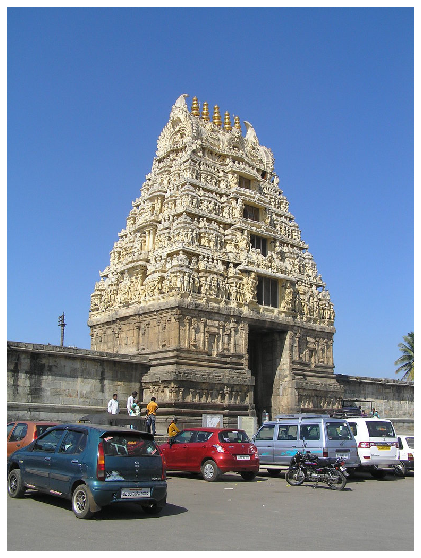

In [91]:
# Get list of .jpg files in car_bbox_out
input_path = glob.glob('../car_detection/test/Car/*.jpg')
print('Found %i images...'%(len(input_path)))

input_path[126]

fig = plt.figure(figsize=(12,10))
plt.axis(False)
im = cv2.imread(input_path[126])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.savefig('../img/scene_demo')


## 2. FasterRCNN on scene, save car instances 

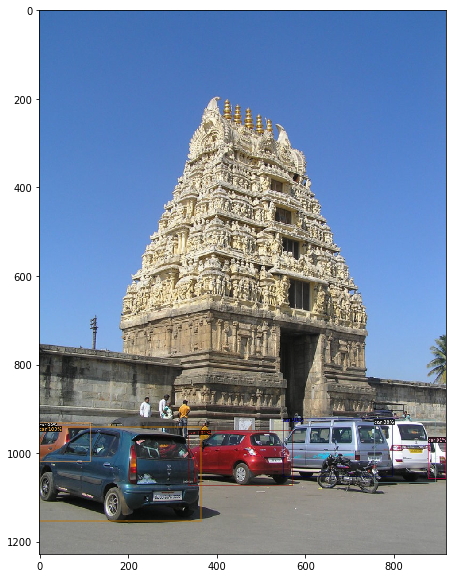

In [93]:
# Model configuration and Default Pre
cfg, predictor = cfg_detectron()
# Predict image
outputs = predictor(im)
carInstance, cars_list = prune_class(outputs)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(carInstance["instances"].to("cpu"))
fig = plt.figure(figsize=(12,10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.savefig('../img/detect_scene_demo')
# cv2.imwrite('carPredictEx.jpg', v.get_image()[:, :, ::-1]) 

# 2.5 Crop each instance and save image to array

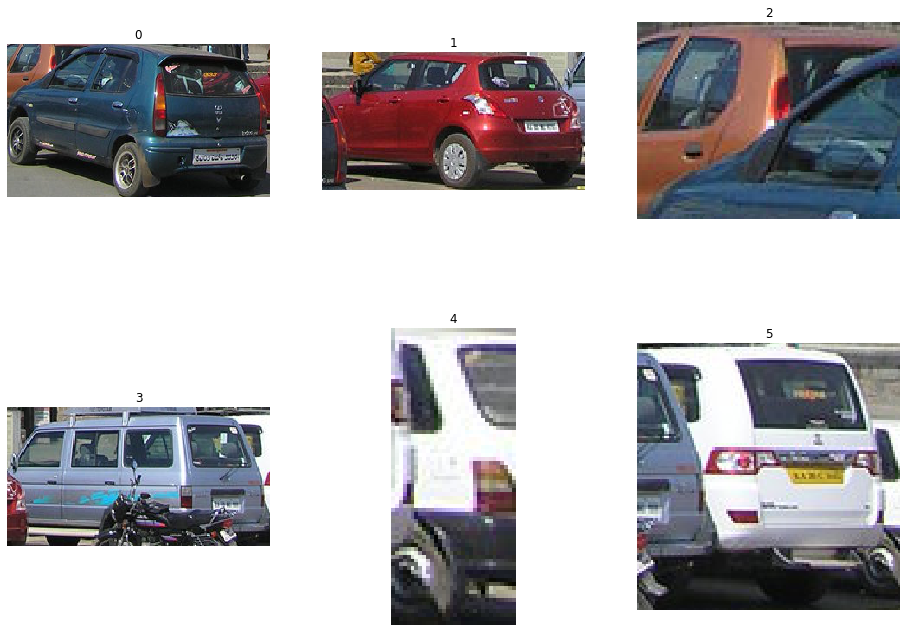

In [94]:
def extract_cars(output_instance, image):
    '''
    Input: Original image (Input for FasterRCNN) and predicted output class Instance
    Output: A list of dictionary of (key:id, val:cropped images of detected car)
    '''
    bboxes = output_instance['instances'].pred_boxes
    
    cars = []

    for ind, instance in enumerate(bboxes.tensor.tolist()):
        # pretty elegant eh? Round each coordinate to int and destructure
        x, y, w, h = [round(num) for num in instance]
        # Crop car instance and save to array     
        cropped_im = im[y:h, x:w]
        car = {
            'id': ind,
            'image': cropped_im
        }
        cars.append(car)
    
    return cars

cars = extract_cars(carInstance, im)

# Plot each detect car from predicted output
fig = plt.figure(figsize=(16,12))
grid = gridspec.GridSpec(ncols=3,nrows=2,figure=fig)

for ind, car in enumerate(cars):
    fig.add_subplot(grid[ind])
    plt.axis(False)
    plt.title(car['id'])
    plt.imshow(car["image"])
plt.savefig('../img/crop_car_scene_demo')


# 3. Detect LPs with WPOD-NET
```
Input: list of cropped images of cars detected in the scene from FasterRCNN
For each image, pass to WPOD-NET to detect a LP and save to array like before
```

In [65]:
wpod_net = load_model('../model/wpod-net.json', '../model/wpod-net.h5')

Loaded WPOD-NET successfully...


(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None
(reconstruct) No LP detected:  list index out of range
(detect_lp) Caught TypeError:  'NoneType' object is not iterable
No LP detected, return None


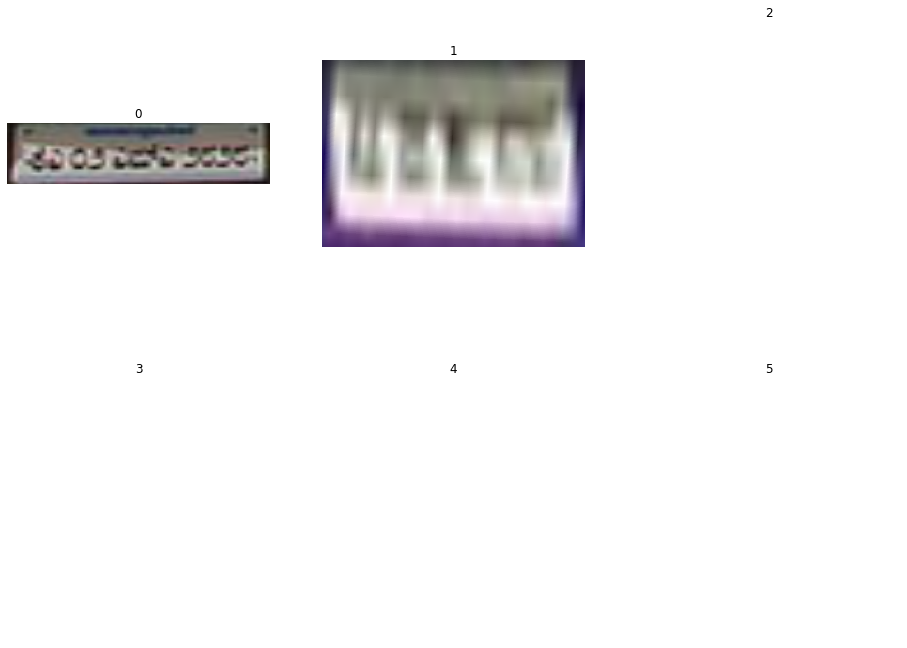

In [95]:
lps = lp_recognition(cars, wpod_net)

# Plot each detect car from predicted output
fig = plt.figure(figsize=(16,12))
grid = gridspec.GridSpec(ncols=3,nrows=2,figure=fig)

for ind, lp in enumerate(lps):
    fig.add_subplot(grid[ind])
    plt.axis(False)
    plt.title(lp['id'])
    try:
        plt.imshow(lp["lp"])
    except TypeError:
        pass
plt.savefig('../img/detect_lp_scene_demo')
    

In [4]:
crop_characters = segmentation(LpImg[0])
lp_chars = detect_lp_chars(crop_characters)


Loaded WPOD-NET successfully...
Loading Recognition Module...
['5']
5
['2']
2
['4']
4
['7']
7
['5']
5


Detect 2 plate(s) in ab64e828b7787162_instance_1
Coordinate of plate(s) in image: 
 [array([[777.36952207, 839.48641641, 836.1337479 , 774.01685357],
       [309.65144024, 293.97912225, 336.3767833 , 352.0491013 ],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[785.97799978, 854.29407769, 861.47695201, 793.16087409],
       [270.23884505, 258.91626603, 285.26875804, 296.59133705],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


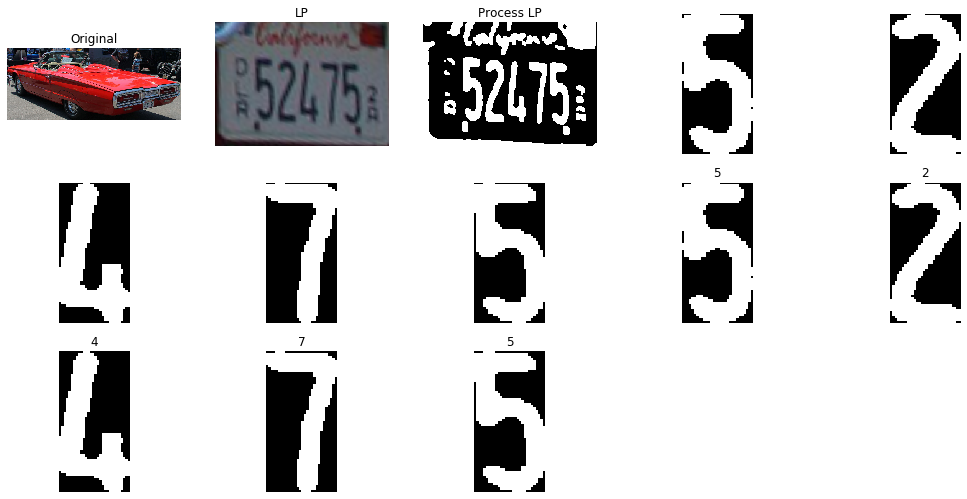

In [6]:
if LpImg:
    print("Detect %i plate(s) in"%len(LpImg),splitext(basename(input_path[270]))[0])
    print("Coordinate of plate(s) in image: \n", cor)
    

    # Visualize our result
    fig = plt.figure(figsize=(18, 15))
    grid = gridspec.GridSpec(ncols=5, nrows=5, figure=fig)
    
    fig.add_subplot(grid[0])
    plt.axis(False)
    plt.title('Original')
    im = cv2.imread(input_path[270])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    
    fig.add_subplot(grid[1])
    plt.axis(False)
    plt.title('LP')
    plt.imshow(LpImg[0])
    
    fig.add_subplot(grid[2])
    plt.axis(False)
    plt.title('Process LP')
    process = process_lp(LpImg[0])
    plt.imshow(process, cmap='gray', vmin = 0, vmax = 255)
    
    for i in range(len(crop_characters)):
        fig.add_subplot(grid[i+3])
        plt.axis(False)
        plt.imshow(crop_characters[i],cmap="gray")
        
    for i in range(len(crop_characters)):
        fig.add_subplot(grid[i+3+len(crop_characters)])
        title = lp_chars[i]
        plt.title('{}'.format(title.strip("'[]"),fontsize=26))
        plt.axis(False)
        plt.imshow(crop_characters[i],cmap="gray")
 
else:
    demo_img = cv2.imread(demo)
    plt.imshow(demo_img)